In [21]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate
import os 

import config as cfg

In [22]:
batch_size = 256

image_classes = ['cored', 'diffuse', 'CAA']

In [23]:
current_module = sys.modules[__name__]
csvs = ['tiles_train', 'tiles_validation', 'tiles_test']
for csv in csvs:
    print('loading {}'.format(csv))
    df_name = csv
    setattr(current_module,
            df_name,
            pd.read_csv(os.path.join('data', 'CSVs', '{}.csv'.format(csv))))
    df = getattr(current_module, df_name)
    print(df.shape)
    display(df.head(2))

loading tiles_train
(155239, 8)


,id,imagename,cored,diffuse,CAA,negative,flag,notsure
0,10748,NA4757-02_AB/NA4757-02_AB_18_25_61.jpg,1.0,0.000000,0.0,0.0,0.0,0.0
1,29503,NA4918-02_AB17-24/NA4918-02_AB17-24_9_18_12.jpg,0.0,2.832462,0.0,0.0,0.0,0.0


loading tiles_validation
(8630, 8)


,id,imagename,cored,diffuse,CAA,negative,flag,notsure
0,0,NA_4896_02_AB17-24/neg_NA_4896_02_AB17-24_0_10...,0.0,0.0,0.0,1.0,0.0,0.0
1,0,NA_4896_02_AB17-24/neg_NA_4896_02_AB17-24_0_18...,0.0,0.0,0.0,1.0,0.0,0.0


loading tiles_test
(10873, 8)


,id,imagename,cored,diffuse,CAA,negative,flag,notsure
0,14,NA4053-02_AB/NA4053-02_AB_18_18.jpg_0.jpg,0.0,3.003472,0.0,0.0,0.28125,1.0
1,15,NA4053-02_AB/NA4053-02_AB_18_18.jpg_1.jpg,0.0,5.214052,0.0,0.0,2.00000,1.0


In [24]:
train_n_validation = pd.concat([tiles_train, tiles_validation])[['imagename'] + image_classes]  
assert train_n_validation.shape[0] == (tiles_train.shape[0] + tiles_validation.shape[0])
test = tiles_test[['imagename'] + image_classes].copy()

In [25]:
threshold = .99
for class_i in image_classes:
    train_n_validation[class_i] = train_n_validation[class_i].map(lambda x: class_i if x > threshold else '')
    test[class_i] = test[class_i].map(lambda x: class_i if x > threshold else '')
    

In [26]:
def create_text_label(df,
                       classes=[],
                       label_col_name='label',
                       negative_class_label='negative'):
    
    df[label_col_name] = df.apply(lambda row: ' '.join(filter(None,
                                                               [row[class_i] for class_i in classes] 
                                                              )), axis=1)
    
    # remove whitespace and label absence of any classes as negative class
    df[label_col_name] = df[label_col_name].map(lambda x: x.strip() if x.strip() else negative_class_label)
    return(df)

train_n_validation = create_text_label(train_n_validation, classes=image_classes)
test = create_text_label(test, classes=image_classes)
train_n_validation.drop(columns=image_classes, inplace=True)
test.drop(columns=image_classes, inplace=True)
display(train_n_validation.head(2))
display(test.head(2))

,imagename,label
0,NA4757-02_AB/NA4757-02_AB_18_25_61.jpg,cored
1,NA4918-02_AB17-24/NA4918-02_AB17-24_9_18_12.jpg,diffuse


,imagename,label
0,NA4053-02_AB/NA4053-02_AB_18_18.jpg_0.jpg,diffuse
1,NA4053-02_AB/NA4053-02_AB_18_18.jpg_1.jpg,diffuse


In [27]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "iframe"

fig = go.Figure()
fig.add_trace(go.Histogram(x=train_n_validation['label'],
                           histnorm='percent',
                           name='train'))
fig.add_trace(go.Histogram(x=test['label'],
                           histnorm='percent',
                           name='test'))

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

In [28]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [29]:
np.random.seed(42)

classes = set(train_n_validation.label.values).union(set(test.label.values))
src = (ImageList.from_df(path=cfg.img_path, df=train_n_validation, folder='all')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))


In [30]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))


In [31]:
resnet50 = models.resnet50

In [32]:
acc_05 = partial(accuracy_thresh, thresh=0.5)
f_score = partial(fbeta, thresh=0.2)

In [33]:
learn = cnn_learner(data, resnet50, metrics=[acc_05, f_score])

In [34]:
model_name = 'stage-6-256-rn50'

In [35]:
learn = learn.load(os.path.join(cfg.models_dir, model_name))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


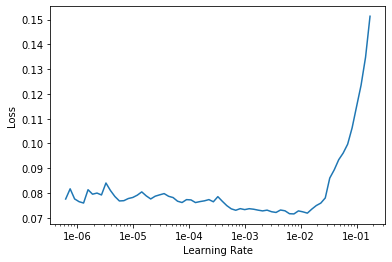

In [36]:
learn.lr_find()
learn.recorder.plot()

In [38]:
lr = 0.01

In [39]:
learn.fit_one_cycle(4, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.079724,0.065973,0.979800,0.969615,20:39
1,0.067444,0.063877,0.979839,0.969121,20:38
2,0.069546,0.063535,0.980090,0.969586,20:38
3,0.061557,0.062819,0.979854,0.969933,20:38


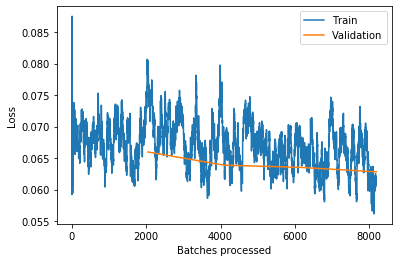

In [40]:
learn.recorder.plot_losses()

In [41]:
learn.save(os.path.join(cfg.models_dir, 'stage-7-256-rn50'))
learn.export(os.path.join(cfg.models_dir, 'stage-7-256-rn50-exported'))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


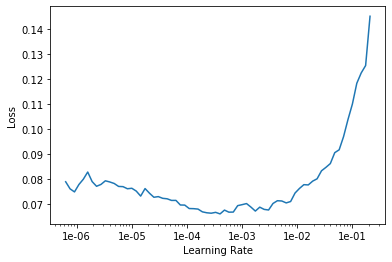

In [42]:
learn.lr_find()
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(3, slice(1e-4, 1e-5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.067516,0.065946,0.980182,0.970561,21:22
1,0.060853,0.065893,0.980045,0.970206,20:37
2,0.063347,0.064955,0.980373,0.970309,20:38


In [44]:
learn.save(os.path.join(cfg.models_dir, 'stage-8-256-rn50'))
learn.export(os.path.join(cfg.models_dir, 'stage-8-256-rn50-exported'))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


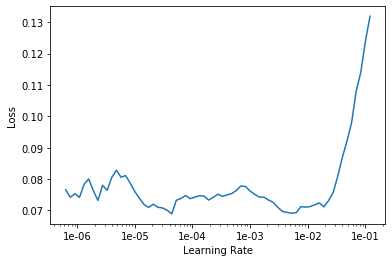

In [45]:
learn.lr_find()
learn.recorder.plot()